# Импорты

In [186]:
import warnings
warnings.filterwarnings('ignore')

In [187]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [188]:
#! pip install category_encoders

In [189]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, f1_score, precision_score, recall_score, confusion_matrix
from category_encoders import CatBoostEncoder

In [190]:
import matplotlib.pyplot as plt
import seaborn as sns

# Данные

## Формирование выборки

In [191]:
genotypes = pd.read_csv('matrix_of_genotypes.csv')
phenotypes = pd.read_csv('phenotypes.csv')
#assert genotypes['sample_id'].equals(phenotypes['sample_id']), "несовпадение id"

In [192]:
genotypes

,rsid,chromosome,position,user10012,user10074,user10077,user10080,user1010,user10123,user1013,...,user9803,user9812,user9839,user9869,user9871,user9876,user9892,user9920,user9928,user9969
0,rs16891982,5,33951693,CG,GG,GG,GG,CG,GG,GG,...,GG,CG,GG,GG,GG,GG,GG,GG,GG,GG
1,rs12203592,6,396321,CC,CT,CT,CT,CC,CC,CT,...,CC,CC,CC,CC,CC,TT,CT,CC,TT,CC
2,rs1393350,11,89011046,GG,GG,GG,AG,GG,GG,GG,...,AG,GG,AG,GG,AG,GG,GG,GG,GG,AG
3,rs12896399,14,92773663,GT,GG,GT,TT,GG,GG,TT,...,GT,GT,GG,GG,GG,GT,GG,GG,TT,GG
4,rs1800407,15,28230318,CC,CC,CC,CC,CC,CC,CT,...,CT,CC,CT,CC,CC,CC,CC,CC,CC,CC
5,rs12913832,15,28365618,AA,GG,GG,GG,AG,GG,AG,...,AG,AG,AG,AG,GG,GG,AG,GG,GG,AG


In [193]:
phenotypes

,user_id,id,eye_colour
0,user10012,10012,Dark brown
1,user10074,10074,Brown-green
2,user10077,10077,Green-gray
3,user10080,10080,Green
4,user1010,1010,Brown
...,...,...,...
802,user9876,9876,Blue
803,user9892,9892,Brown-amber
804,user9920,9920,"Blue-green; amber collarette, and gray-blue ri..."
805,user9928,9928,Blue-green


In [194]:
genotypes_long = genotypes.melt(id_vars=['rsid', 'chromosome', 'position'],
                                var_name='user_id',
                                value_name='genotype')
genotypes_long.head()

,rsid,chromosome,position,user_id,genotype
0,rs16891982,5,33951693,user10012,CG
1,rs12203592,6,396321,user10012,CC
2,rs1393350,11,89011046,user10012,GG
3,rs12896399,14,92773663,user10012,GT
4,rs1800407,15,28230318,user10012,CC


In [195]:
genotypes_long = genotypes_long[['position', 'user_id', 'genotype']]

In [196]:
genotypes_long

,position,user_id,genotype
0,33951693,user10012,CG
1,396321,user10012,CC
2,89011046,user10012,GG
3,92773663,user10012,GT
4,28230318,user10012,CC
...,...,...,...
4837,396321,user9969,CC
4838,89011046,user9969,AG
4839,92773663,user9969,GG
4840,28230318,user9969,CC


In [197]:
genotypes_long['position'] = genotypes_long.groupby('user_id').cumcount() # нумерация
genotypes_long.head()

,position,user_id,genotype
0,0,user10012,CG
1,1,user10012,CC
2,2,user10012,GG
3,3,user10012,GT
4,4,user10012,CC


In [198]:
genotypes_pivot = genotypes_long.pivot(index='user_id', columns='position', values='genotype')
genotypes_pivot

position,0,1,2,3,4,5
user_id,,,,,,
user10012,CG,CC,GG,GT,CC,AA
user10074,GG,CT,GG,GG,CC,GG
user10077,GG,CT,GG,GT,CC,GG
user10080,GG,CT,AG,TT,CC,GG
user1010,CG,CC,GG,GG,CC,AG
...,...,...,...,...,...,...
user9876,GG,TT,GG,GT,CC,GG
user9892,GG,CT,GG,GG,CC,AG
user9920,GG,CC,GG,GG,CC,GG


In [199]:
genotypes_pivot.reset_index(inplace=True)
final_df = pd.merge(phenotypes, genotypes_pivot, on='user_id')
final_df

,user_id,id,eye_colour,0,1,2,3,4,5
0,user10012,10012,Dark brown,CG,CC,GG,GT,CC,AA
1,user10074,10074,Brown-green,GG,CT,GG,GG,CC,GG
2,user10077,10077,Green-gray,GG,CT,GG,GT,CC,GG
3,user10080,10080,Green,GG,CT,AG,TT,CC,GG
4,user1010,1010,Brown,CG,CC,GG,GG,CC,AG
...,...,...,...,...,...,...,...,...,...
802,user9876,9876,Blue,GG,TT,GG,GT,CC,GG
803,user9892,9892,Brown-amber,GG,CT,GG,GG,CC,AG
804,user9920,9920,"Blue-green; amber collarette, and gray-blue ri...",GG,CC,GG,GG,CC,GG
805,user9928,9928,Blue-green,GG,TT,GG,TT,CC,GG


In [200]:
final_df['eye_colour'].unique()

array(['Dark brown', 'Brown-green', 'Green-gray', 'Green', 'Brown',
       'Hazel', 'Blue', 'Hazel (brown/green)',
       'Blue, grey, green, changing', 'Blue-green', 'Hazel/light brown',
       'Rs12913832 aa', 'Blue-green-grey', 'Green-hazel', 'Mixed',
       'Blue-grey', 'Blue-grey with central heterochromia', 'Gray-blue',
       'Black', 'Blue-grey; broken amber collarette',
       'Rs12913832 ag (they', 'Gg', 'Brown-amber', 'Brown/black',
       'Rs12913832 gg', 'Green-brown', 'Light-mixed green', 'Dark blue',
       'Indeterminate brown-green with a subtle grey caste', 'Grey brown',
       'Olive-Brown ringing Burnt Umber-Brown', 'Blue with yellow parts',
       'Ambar-Green', 'Brown-(green when external temperature rises)',
       'Ambar-green', 'Olive-brown ringing burnt umber-brown',
       'Blue grey', 'Brown - Brown and green in bright sunlight',
       'Brown - brown and green in bright sunlight', 'Light blue-green',
       'Split - one side dark blue / other side light blu

In [201]:
# Функция для маппинга цвета глаз
def map_eye_colour(eye_colour):
    eye_colour = eye_colour.lower()
    if 'blue' in eye_colour or 'rs12913832' in eye_colour:
        return 'blue'
    elif 'green' in eye_colour:
        return 'green'
    elif 'brown' in eye_colour or 'hazel' in eye_colour or 'amber' in eye_colour or 'black' in eye_colour:
        return 'brown'
    elif 'grey' in eye_colour or 'gray' in eye_colour:
        return 'gray'
    elif 'mixed' in eye_colour or 'gg' in eye_colour:
        return 'mixed'
    else:
        return 'unknown'


final_df['eye_colour'] = final_df['eye_colour'].apply(map_eye_colour)

In [202]:
final_df['eye_colour'].unique()

array(['brown', 'green', 'blue', 'mixed'], dtype=object)

Rs12913832 отвечает за blue

Получаем датафрейм с выборкой
- eye_colour - таргет
- нуклеотиды в определенных позициях считаются фичами

# Анализ данных

In [203]:
data = final_df.copy()

In [204]:
colour_counts = data['eye_colour'].value_counts()
colour_counts_df = colour_counts.reset_index()
colour_counts_df.columns = ['eye_colour', 'frequency']

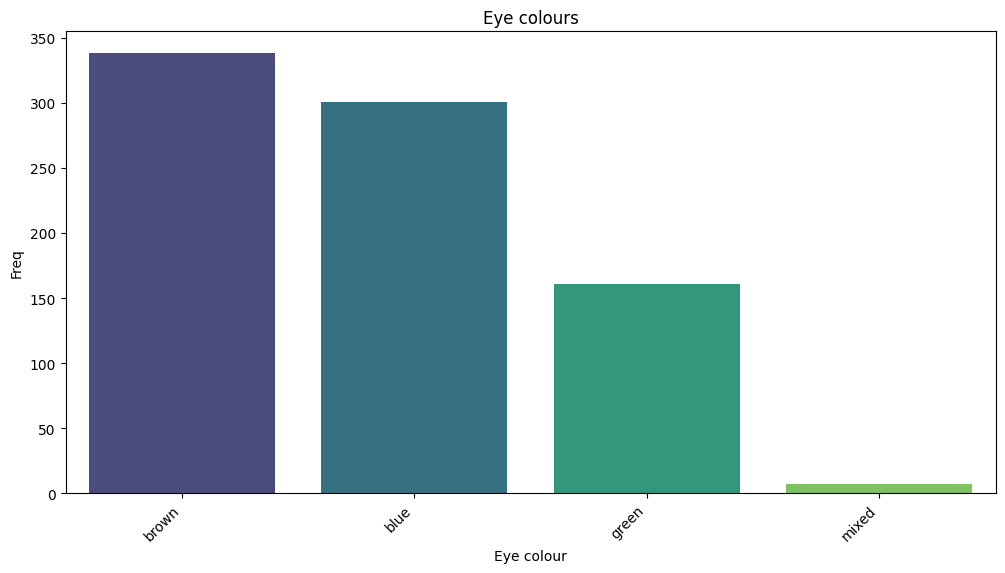

In [205]:
plt.figure(figsize=(12, 6))
sns.barplot(x='eye_colour', y='frequency', data=colour_counts_df, palette='viridis')
plt.title('Eye colours')
plt.xlabel('Eye colour')
plt.ylabel('Freq')
plt.xticks(rotation=45, ha='right')
plt.show()

 чтож..... mixed почти нет, но непонятно, каким его сделать

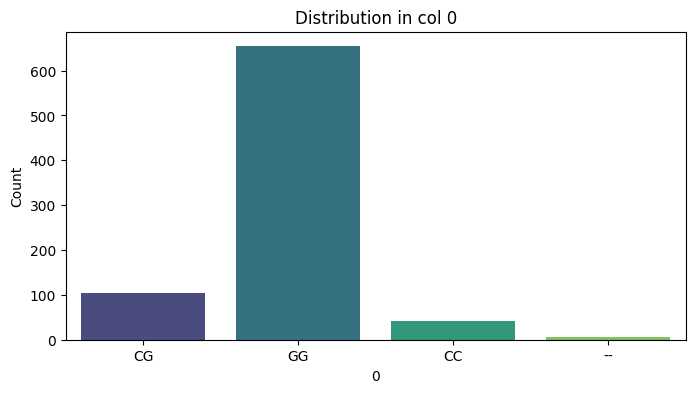

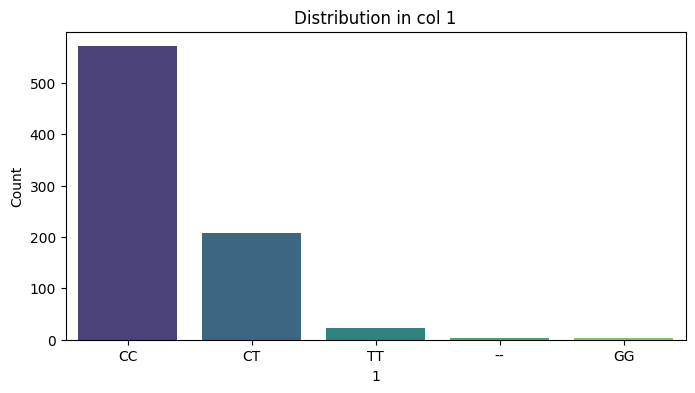

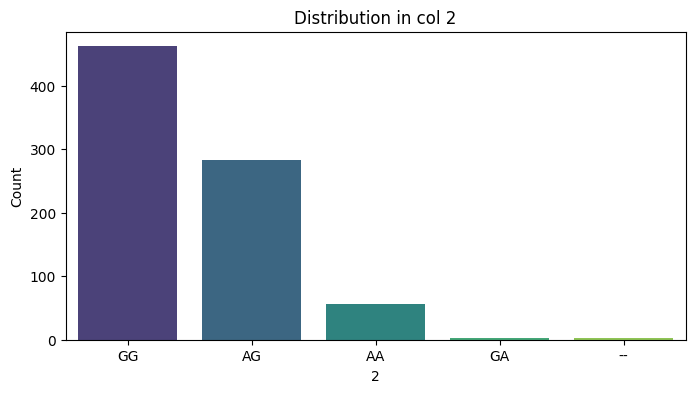

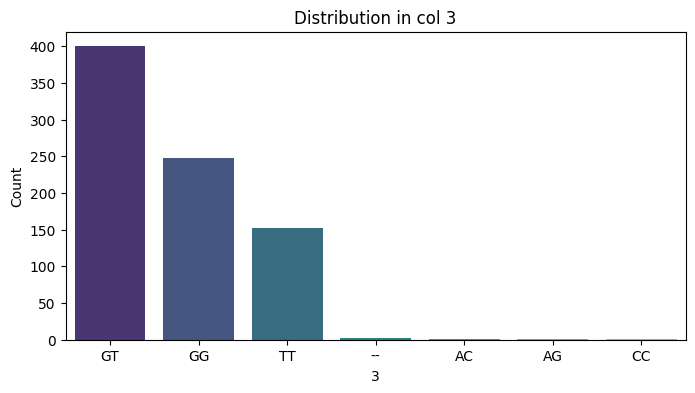

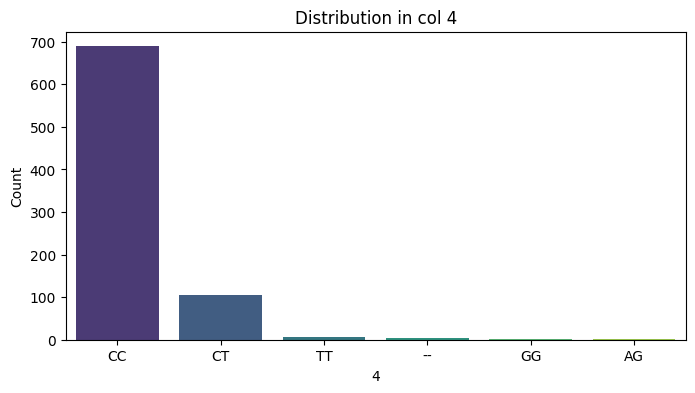

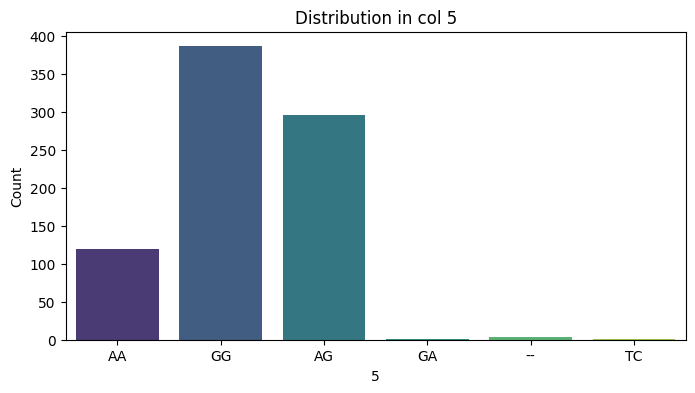

In [206]:
for c in range(0, 6):
    plt.figure(figsize=(8, 4))
    sns.countplot(x=data[c], palette='viridis')
    plt.title(f'Distribution in col {c}')
    plt.ylabel('Count')
    plt.show()

Данных мало, классы несбалансированные, но должна быть явная корреляция цвета глаз и замен, поэтому обучиться должно

## Предобработка

In [207]:
data = data.drop(columns=['user_id', 'id'])

Закодируем категориальные данные

In [208]:
# Кодируем столбец eye_colour с помощью LabelEncoder
label_encoder = LabelEncoder()
data['eye_colour'] = label_encoder.fit_transform(data['eye_colour'])

In [209]:
data.head()

,eye_colour,0,1,2,3,4,5
0,1,CG,CC,GG,GT,CC,AA
1,2,GG,CT,GG,GG,CC,GG
2,2,GG,CT,GG,GT,CC,GG
3,2,GG,CT,AG,TT,CC,GG
4,1,CG,CC,GG,GG,CC,AG


In [210]:
data.columns[1:]

Index([0, 1, 2, 3, 4, 5], dtype='object')

для фичей используем OHE

In [211]:
ohe_data = pd.get_dummies(data, columns=[0, 1, 2, 3, 4, 5])

In [212]:
ohe_data.head()

,eye_colour,0_--,0_CC,0_CG,0_GG,1_--,1_CC,1_CT,1_GG,1_TT,...,4_CC,4_CT,4_GG,4_TT,5_--,5_AA,5_AG,5_GA,5_GG,5_TC
0,1,False,False,True,False,False,True,False,False,False,...,True,False,False,False,False,True,False,False,False,False
1,2,False,False,False,True,False,False,True,False,False,...,True,False,False,False,False,False,False,False,True,False
2,2,False,False,False,True,False,False,True,False,False,...,True,False,False,False,False,False,False,False,True,False
3,2,False,False,False,True,False,False,True,False,False,...,True,False,False,False,False,False,False,False,True,False
4,1,False,False,True,False,False,True,False,False,False,...,True,False,False,False,False,False,True,False,False,False


# Обучение

## трейн и таргет

In [213]:
X = ohe_data.drop('eye_colour', axis=1)
y = ohe_data['eye_colour']

## тест и трейн

In [214]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [215]:
X_test.shape

(243, 33)

In [216]:
X_train.shape

(564, 33)

## Выбор модели


In [217]:
models = {
    'Log reg': LogisticRegression(max_iter=1000),
    'RF': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'SVM': SVC(),
    'knn': KNeighborsClassifier()
}

In [218]:
def compare_models(models, X_train, X_test, y_train, y_test):
    results = {}

    for name, model in models.items():
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')

        results[name] = {
            'accuracy': accuracy_score(y_test, y_pred),
            'F1-score': f1_score(y_test, y_pred, average='weighted')
        }
    for model, metrics in results.items():
        print(f"{model}:\n")
        for metric, value in metrics.items():
            print(f"{metric}: {value}\n")
        print("--------" * 10)

In [219]:
compare_models(models, X_train, X_test, y_train, y_test)

Log reg:

accuracy: 0.7366255144032922

F1-score: 0.6649023351274322

--------------------------------------------------------------------------------
RF:

accuracy: 0.7283950617283951

F1-score: 0.6931977150104824

--------------------------------------------------------------------------------
Gradient Boosting:

accuracy: 0.720164609053498

F1-score: 0.6610022390345254

--------------------------------------------------------------------------------
SVM:

accuracy: 0.7366255144032922

F1-score: 0.6648377929668136

--------------------------------------------------------------------------------
knn:

accuracy: 0.6954732510288066

F1-score: 0.6314130867660553

--------------------------------------------------------------------------------


Не так плохо :) Можно попробовать закодировать данные иначе. Если не станет лучше, то буду подбирать гиперпараметры

# Другой вариант кодировки

Попробуем частотную кодировку. OHE дает слишком разряженную матрицу и метрики так себе, возьмем частотную кодировку из кэтбуста, поскольку в алгоритме учтено то, чтобы не было лика на таргет

In [220]:
data.head()

,eye_colour,0,1,2,3,4,5
0,1,CG,CC,GG,GT,CC,AA
1,2,GG,CT,GG,GG,CC,GG
2,2,GG,CT,GG,GT,CC,GG
3,2,GG,CT,AG,TT,CC,GG
4,1,CG,CC,GG,GG,CC,AG


In [221]:
X = data.drop('eye_colour', axis=1)
y = data['eye_colour']

In [222]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [223]:
encoder = CatBoostEncoder(cols=[0, 1, 2, 3, 4, 5])
X_train_encoded = encoder.fit_transform(X_train, y_train)
X_test_encoded = encoder.transform(X_test)

In [224]:
compare_models(models, X_train_encoded, X_test_encoded, y_train, y_test)

Log reg:

accuracy: 0.7469135802469136

F1-score: 0.6564345271125909

--------------------------------------------------------------------------------
RF:

accuracy: 0.7469135802469136

F1-score: 0.6587403967434927

--------------------------------------------------------------------------------
Gradient Boosting:

accuracy: 0.7345679012345679

F1-score: 0.6561546429271297

--------------------------------------------------------------------------------
SVM:

accuracy: 0.7469135802469136

F1-score: 0.6564345271125909

--------------------------------------------------------------------------------
knn:

accuracy: 0.7345679012345679

F1-score: 0.6972505516788932

--------------------------------------------------------------------------------


# Подбор гиперпараметров наиболее оптимальных моделей

## Логистическая регрессия

In [230]:
log_reg = LogisticRegression(random_state=42, max_iter=1000)

param_grid_log_reg = {
    'C': [0.1, 1, 10, 100],
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'solver': ['lbfgs', 'liblinear', 'saga']
}

In [231]:
grid_search_log_reg = GridSearchCV(estimator=log_reg,
                                   param_grid=param_grid_log_reg,
                                   cv=3,
                                   n_jobs=-1,
                                   verbose=2,
                                   scoring='accuracy')

grid_search_log_reg.fit(X_train_encoded, y_train)

print("лучшие параметры: ", grid_search_log_reg.best_params_)
best_log_reg = grid_search_log_reg.best_estimator_
y_pred_log_reg = best_log_reg.predict(X_test_encoded)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
лучшие параметры:  {'C': 0.1, 'penalty': 'l1', 'solver': 'saga'}


In [233]:
print("accuracy: ", accuracy_score(y_test, y_pred_log_reg))
print("classification Report:\n", classification_report(y_test, y_pred_log_reg))

accuracy:  0.7469135802469136
classification Report:
               precision    recall  f1-score   support

           0       0.75      0.97      0.85        60
           1       0.74      0.94      0.83        67
           2       0.00      0.00      0.00        34
           3       0.00      0.00      0.00         1

    accuracy                           0.75       162
   macro avg       0.37      0.48      0.42       162
weighted avg       0.59      0.75      0.66       162



## SVM

In [225]:
svm = SVC(random_state=42)

param_grid_svm = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

In [226]:
grid_search_svm = GridSearchCV(estimator=svm,
                               param_grid=param_grid_svm,
                               cv=3,
                               n_jobs=-1,
                               verbose=2,
                               scoring='accuracy')

grid_search_svm.fit(X_train_encoded, y_train)

print("Лучшие параметры: ", grid_search_svm.best_params_)
best_svm = grid_search_svm.best_estimator_
y_pred_svm = best_svm.predict(X_test_encoded)

print("accuracy: ", accuracy_score(y_test, y_pred_svm))
print("classification Report:\n", classification_report(y_test, y_pred_svm))

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Лучшие параметры:  {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
accuracy:  0.7469135802469136
classification Report:
               precision    recall  f1-score   support

           0       0.75      0.97      0.85        60
           1       0.74      0.94      0.83        67
           2       0.00      0.00      0.00        34
           3       0.00      0.00      0.00         1

    accuracy                           0.75       162
   macro avg       0.37      0.48      0.42       162
weighted avg       0.59      0.75      0.66       162



## Random forest

In [228]:
rf = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [100, 150, 200, 250],
    'max_depth': [10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

In [229]:
grid_search = GridSearchCV(estimator=rf,
                           param_grid=param_grid,
                           cv=3,
                           n_jobs=-1,
                           verbose=2,
                           scoring='accuracy')

grid_search.fit(X_train_encoded, y_train)

print("Лучшие параметры: ", grid_search.best_params_)
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test_encoded)

print("accuracy: ", accuracy_score(y_test, y_pred))
print("classification Report:\n", classification_report(y_test, y_pred))

Fitting 3 folds for each of 540 candidates, totalling 1620 fits
Лучшие параметры:  {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 250}
accuracy:  0.7469135802469136
classification Report:
               precision    recall  f1-score   support

           0       0.76      0.97      0.85        60
           1       0.74      0.94      0.83        67
           2       0.00      0.00      0.00        34
           3       0.00      0.00      0.00         1

    accuracy                           0.75       162
   macro avg       0.38      0.48      0.42       162
weighted avg       0.59      0.75      0.66       162

